In [1]:
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt
%matplotlib inline
from game import game, random_connection_game_initialstate, random_connection_game

In [2]:
import time
from IPython.display import clear_output

In [3]:
def randomAgent(state, Memb = 25):
    #move = random.randint(3)
    spin_1 = random.randint(Memb)
    spin_2 = random.randint(4)
    return (spin_1, spin_2)

In [4]:
Memb = 4*4

env = random_connection_game(4,  Memb, 
                             max_consecutive_failures = 50)

In [5]:
state = env.reset()
print(env.H.shape, env.Hemb.shape, env.Hmask.shape,
      env.state.shape)

(4, 4) (16, 16) (16, 16) (2, 16, 16)


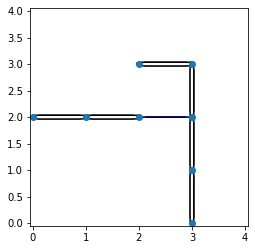

0.6875 8 (1, 0) -1


In [6]:
env = random_connection_game(2,  Memb, 
                             max_consecutive_failures = 50)
env.reset()
#
state = env.state
fig, ax = env.plot()
score = 0.0
actions = []
for j in range(100):
    clear_output(wait=True)
    #randomAgent(state, Memb)#
    action = randomAgent(state, Memb)
    state, reward, done =env.step(action)
    score += reward
    actions.append((*action, reward))

    fig, ax = env.plot()
    plt.show()
    print(score, env.N, action, env.terms_left)
    if done >0:
        break

In [7]:
state = env.reset()

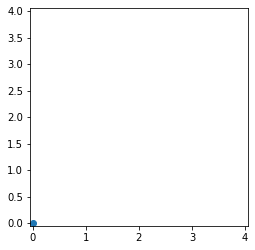

-0.0125 1 (0, 3) 3 0


In [8]:
score = 0.0
action = randomAgent(state, Memb)
state, reward, done = env.step(action)
score += reward
actions.append((*action, reward))

fig, ax = env.plot()
plt.show()
print(score, env.N, action, env.terms_left, done)

In [9]:
action

(0, 3)

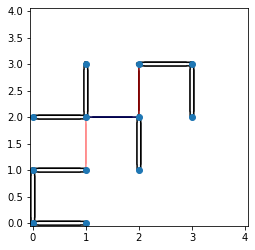

-0.46250000000000013 12 4 4 (13, 3) 0


In [10]:
# Reset!
Memb = 16

env = random_connection_game(9,  Memb, 
                             max_consecutive_failures = 50)

state = env.reset()
fig, ax = env.plot()
score = 0.0
actions = []
for j in range(20):
    clear_output(wait=True)

    action = randomAgent(state, Memb)
    state, reward, done =env.step(action)
    score += reward
    actions.append((*action, reward))

    fig, ax = env.plot()
    plt.show()
    print(score, env.N, env.N0,env.nS,action, env.terms_left)
    if done >0:
        break